[]


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LassoCV

# Load Dataset
# for kaggle

# dataset_path = "/kaggle/input/cicids-17/merged_output.csv"

# data = pd.read_csv(dataset_path)

# for local
data=pd.read_csv('merged_output.csv', encoding='utf-8')
data.columns = data.columns.str.strip()

# Remove infinite values and NaNs
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Define Features and Target
y = data['Label']
X = data.drop('Label', axis=1)

# Label Encoding for Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = y_encoded

# Remove constant features
constant_features = [col for col in X.columns if X[col].nunique() == 1]
X.drop(columns=constant_features, inplace=True)

# Standard Scaling for most methods
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=['Label'])
y_test = pd.DataFrame(y_test, columns=['Label'])


ensemble_features = ['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max',
       'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'PSH Flag Count', 'Average Packet Size',
       'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']

print(len(X_train.columns))
print(len(X_test.columns))


X_train = X_train[ensemble_features]
X_test = X_test[ensemble_features]

print(len(X_train))
print(len(X_test))

70
70
1886070
471518


decision tree without handling imbalance

--- Training Evaluation ---
Accuracy: 0.9856
Precision: 0.9858
Recall: 0.9856
F1-score: 0.9847
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1522420
           1       1.00      0.62      0.77      1565
           2       1.00      1.00      1.00    102420
           3       1.00      0.80      0.88    110748
           4       0.98      1.00      0.99      4399
           5       1.00      1.00      1.00      4637
           6       0.96      1.00      0.98      6348
           7       1.00      0.97      0.98        29
           8       0.99      1.00      1.00    127043
           9       1.00      0.51      0.68      4717
          10       1.00      0.91      0.95      1205
          11       1.00      0.65      0.79        17
          12       1.00      0.97      0.98       522

    accuracy                           0.99   1886070
   macro avg       0.99      0.88      0.92   1886070
weighted avg       0.99      0.99      

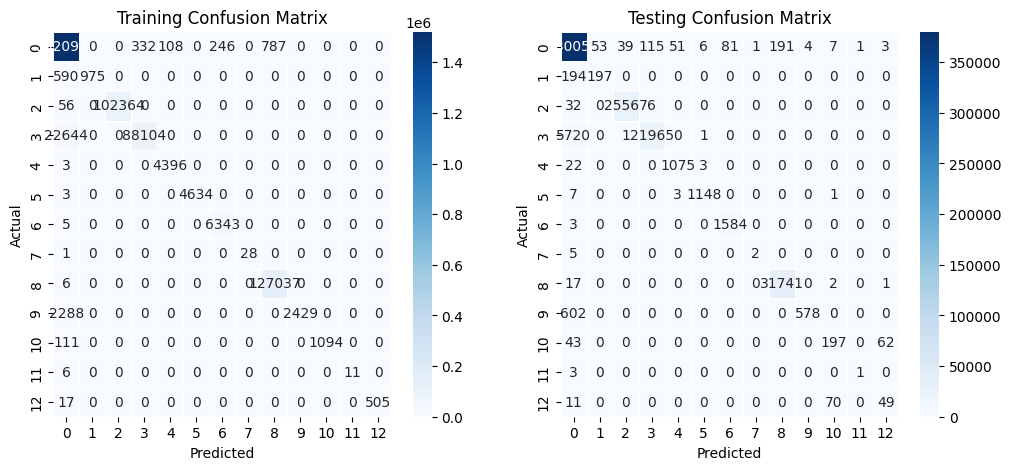

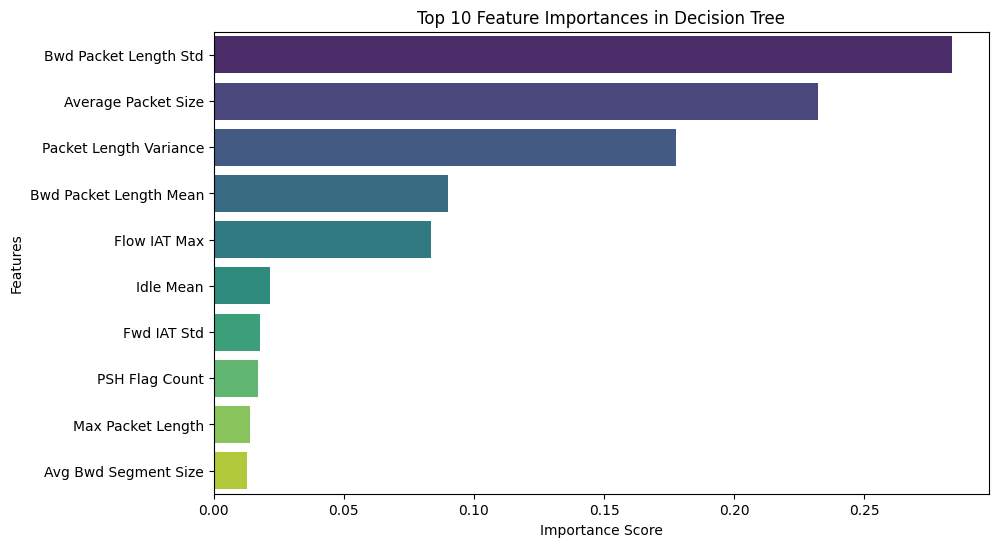

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize Decision Tree model with class weight handling for imbalance
dt = DecisionTreeClassifier(random_state=42)

# Train model
dt.fit(X_train, y_train)

# Predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Accuracy
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)

# Precision, Recall, F1-score
train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

# Print Evaluation Metrics
print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

# Feature Importance Visualization
feature_importance = dt.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx][:10], y=np.array(X_train.columns)[sorted_idx][:10], palette="viridis")
plt.title("Top 10 Feature Importances in Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


decision tree with imbalance handling

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Training Evaluation ---
Accuracy: 0.8763
Precision: 0.9957
Recall: 0.8763
F1-score: 0.9297
              precision    recall  f1-score   support

           0       1.00      0.86      0.93   1522420
           1       0.04      1.00      0.07      1565
           2       1.00      1.00      1.00    102420
           3       1.00      0.80      0.88    110748
           4       0.98      1.00      0.99      4399
           5       1.00      1.00      1.00      4637
           6       0.96      1.00      0.98      6348
           7       0.00      1.00      0.00        29
           8       0.99      1.00      1.00    127043
           9       0.03      1.00      0.06      4717
          10       1.00      0.91      0.95      1205
          11       1.00      0.65      0.79        17
          12       0.48      0.97      0.65       522

    accuracy                           0.88   1886070
   macro avg       0.73      0.94      0.71   1886070
weighted avg       1.00      0.88      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.86      0.93    380605
           1       0.03      0.85      0.06       391
           2       1.00      1.00      1.00     25605
           3       0.99      0.79      0.88     27687
           4       0.95      0.98      0.97      1100
           5       0.99      0.99      0.99      1159
           6       0.95      1.00      0.97      1587
           7       0.00      0.71      0.00         7
           8       0.99      1.00      1.00     31761
           9       0.03      0.99      0.06      1180
          10       0.71      0.66      0.68       302
          11       0.00      0.00      0.00         4
          12       0.17      0.38      0.24       130

    accuracy                           0.88    471518
   macro avg       0.60      0.79      0.60    471518
weighted avg       0.99      0.88      0.93    471518



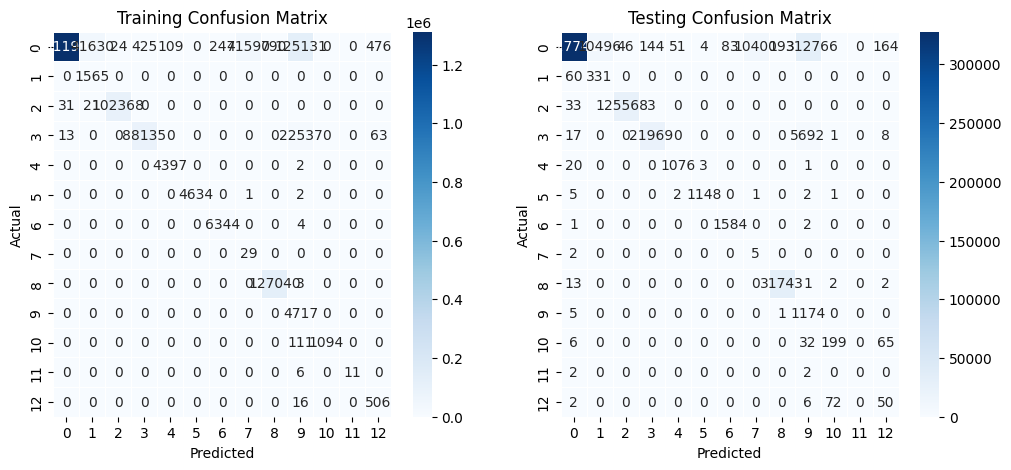

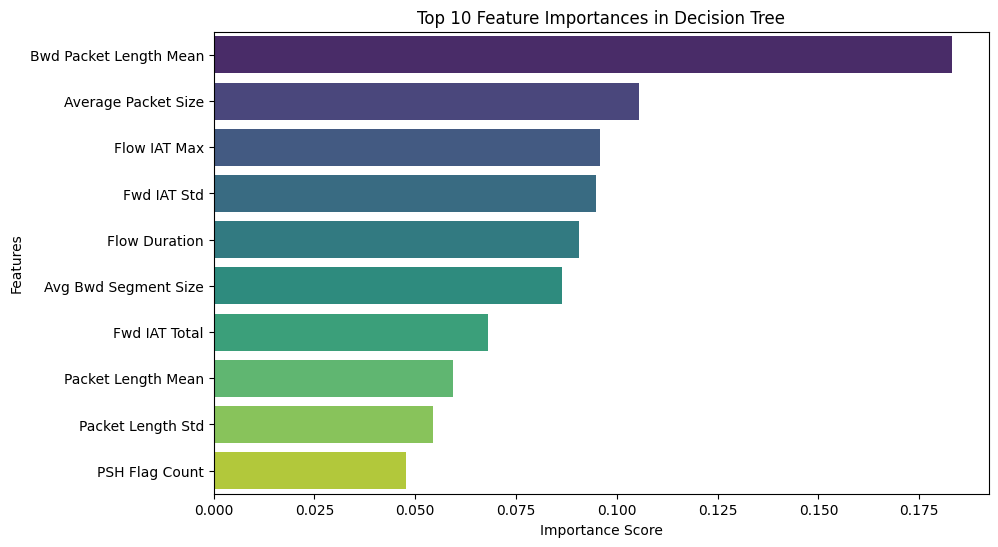

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize Decision Tree model with class weight handling for imbalance
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Train model
dt.fit(X_train, y_train)

# Predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Accuracy
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)

# Precision, Recall, F1-score
train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

# Print Evaluation Metrics
print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

# Feature Importance Visualization
feature_importance = dt.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx][:10], y=np.array(X_train.columns)[sorted_idx][:10], palette="viridis")
plt.title("Top 10 Feature Importances in Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize MLP model
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=300, random_state=42)

# Train model
mlp.fit(X_train, y_train)

# Predictions for Training & Testing sets
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# Accuracy
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)

# Precision, Recall, F1-score
train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

# Print Evaluation Metrics
print(f"--- MLP Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- MLP Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("MLP Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("MLP Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
print(len(X_train.columns))
print(len(X_test.columns))

20
20


xgboost with handling  imbalance

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:18:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Training Evaluation ---
Accuracy: 0.9865
Precision: 0.9861
Recall: 0.9865
F1-score: 0.9855


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1522420
           1       1.00      0.36      0.53      1565
           2       1.00      1.00      1.00    102420
           3       0.97      0.86      0.91    110748
           4       0.96      0.98      0.97      4399
           5       0.99      0.99      0.99      4637
           6       1.00      0.98      0.99      6348
           7       0.00      0.00      0.00        29
           8       0.99      1.00      1.00    127043
           9       1.00      0.50      0.67      4717
          10       0.99      0.06      0.12      1205
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00       522

    accuracy                           0.99   1886070
   macro avg       0.76      0.60      0.63   1886070
weighted avg       0.99      0.99      0.99   1886070


--- Testing Evaluation ---
Accuracy: 0.9861
Precision: 0.9857
Recall: 0.9861
F

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    380605
           1       1.00      0.38      0.55       391
           2       1.00      1.00      1.00     25605
           3       0.96      0.86      0.91     27687
           4       0.97      0.97      0.97      1100
           5       1.00      0.98      0.99      1159
           6       1.00      0.99      0.99      1587
           7       0.00      0.00      0.00         7
           8       0.99      1.00      1.00     31761
           9       1.00      0.48      0.65      1180
          10       0.93      0.04      0.08       302
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00       130

    accuracy                           0.99    471518
   macro avg       0.76      0.59      0.63    471518
weighted avg       0.99      0.99      0.99    471518



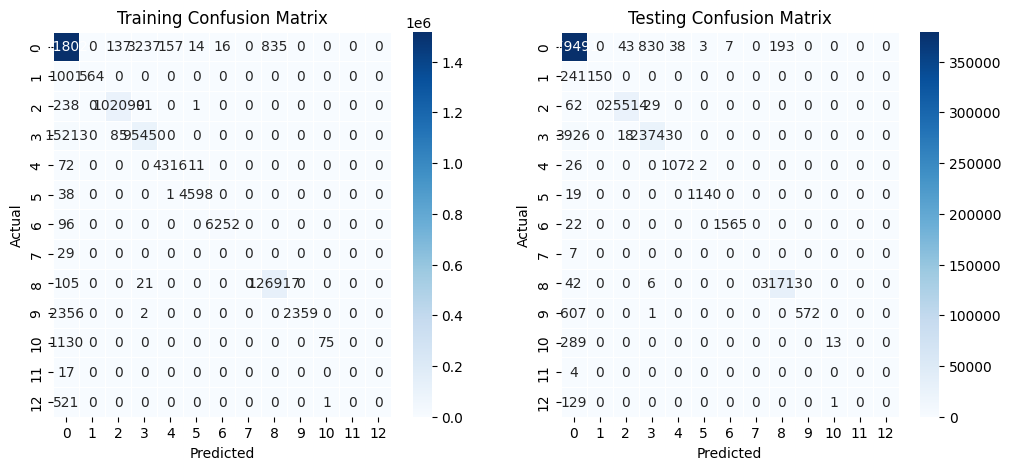

In [ ]:
import xgboost as xgb
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute class weights using balanced strategy
class_counts = Counter(y_train)
max_count = max(class_counts.values())
scale_pos_weights = {cls: max_count / count for cls, count in class_counts.items()}

# Convert to list in correct order
class_weight_list = np.array([scale_pos_weights[label] for label in sorted(class_counts.keys())])

# Initialize XGBoost model with class weights
xg = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    gamma=2,
    tree_method="auto",
    objective="multi:softmax",  # Multi-class classification
    num_class=len(class_counts),  # Number of classes
    scale_pos_weight=class_weight_list,  # Class-specific weighting
    eval_metric="mlogloss",
    random_state=42
)

# Train model
xg.fit(X_train, y_train)

# Predictions for Training & Testing sets
y_train_pred = xg.predict(X_train)
y_test_pred = xg.predict(X_test)

# Accuracy
train_accuracy = xg.score(X_train, y_train)
test_accuracy = xg.score(X_test, y_test)

# Precision, Recall, F1-score
train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

# Print Evaluation Metrics
print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

random forest with imbalance handling


--- Training Evaluation ---
Accuracy: 0.9353
Precision: 0.9843
Recall: 0.9353
F1-score: 0.9565
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1522420
           1       0.05      1.00      0.09      1565
           2       1.00      1.00      1.00    102420
           3       0.81      1.00      0.89    110748
           4       1.00      1.00      1.00      4399
           5       0.99      1.00      0.99      4637
           6       0.96      1.00      0.98      6348
           7       0.34      1.00      0.50        29
           8       0.99      1.00      1.00    127043
           9       0.08      0.94      0.14      4717
          10       0.18      0.93      0.31      1205
          11       0.00      0.94      0.01        17
          12       0.32      0.99      0.48       522

    accuracy                           0.94   1886070
   macro avg       0.59      0.98      0.64   1886070
weighted avg       0.98      0.94      

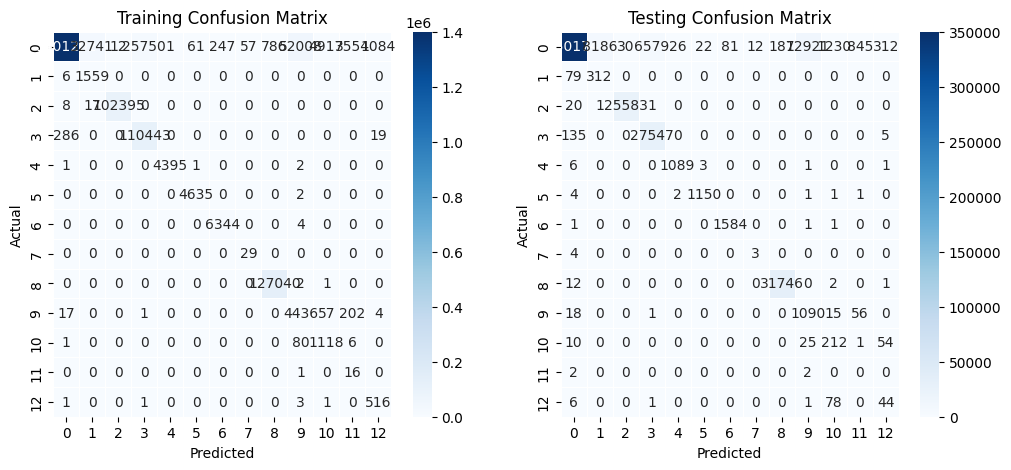

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_train is a 1D NumPy array
y_train = np.array(y_train).ravel()

# Compute Class Weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Initialize Random Forest model with class weights
rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight=class_weight_dict)

# Train model
rf.fit(X_train, y_train)

# Predictions for Training & Testing sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Accuracy
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

# Precision, Recall, F1-score
train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

# Print Evaluation Metrics
print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


random forest without imbalance handling

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Training Evaluation ---
Accuracy: 0.9886
Precision: 0.9886
Recall: 0.9886
F1-score: 0.9883
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1522420
           1       1.00      0.62      0.77      1565
           2       1.00      1.00      1.00    102420
           3       0.93      0.91      0.92    110748
           4       1.00      1.00      1.00      4399
           5       1.00      1.00      1.00      4637
           6       1.00      0.99      0.99      6348
           7       1.00      0.97      0.98        29
           8       0.99      1.00      1.00    127043
           9       1.00      0.52      0.68      4717
          10       1.00      0.91      0.95      1205
          11       1.00      0.65      0.79        17
          12       1.00      0.96      0.98       522

    accuracy                           0.99   1886070
   macro avg       0.99      0.89      0.93   1886070
weighted avg       0.99      0.99      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    380605
           1       0.82      0.48      0.61       391
           2       1.00      1.00      1.00     25605
           3       0.92      0.91      0.92     27687
           4       0.97      0.99      0.98      1100
           5       1.00      0.99      1.00      1159
           6       1.00      0.99      0.99      1587
           7       1.00      0.43      0.60         7
           8       0.99      1.00      1.00     31761
           9       1.00      0.49      0.66      1180
          10       0.74      0.70      0.72       302
          11       0.00      0.00      0.00         4
          12       0.46      0.38      0.42       130

    accuracy                           0.99    471518
   macro avg       0.84      0.72      0.76    471518
weighted avg       0.99      0.99      0.99    471518



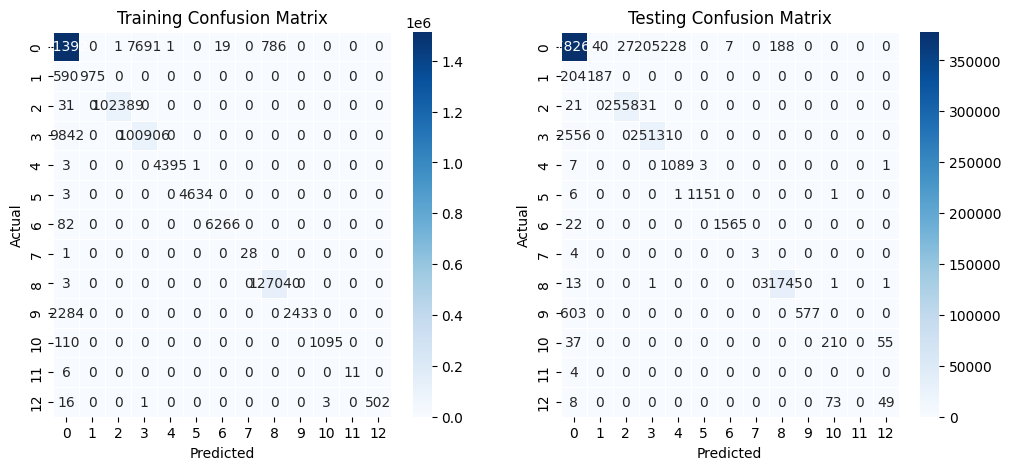

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=50, random_state=42 , class_weight="balanced_subsample")

# Train model
rf.fit(X_train, y_train)

# Predictions for Training & Testing sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Accuracy
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

# Precision, Recall, F1-score
train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

# Print Evaluation Metrics
print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize SVM model
svm = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')

# Train model
svm.fit(X_train, y_train)

# Predictions for Training & Testing sets
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Accuracy
train_accuracy = svm.score(X_train, y_train)
test_accuracy = svm.score(X_test, y_test)

# Precision, Recall, F1-score
train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

# Print Evaluation Metrics
print(f"--- SVM Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- SVM Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("SVM Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("SVM Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
